In [1]:
#https://github.com/Tony607/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
LABELS = ["Normal", "Fraud"]
df = pd.read_csv("creditcard.csv")

In [3]:
#data.to_csv("pca111.csv")

In [4]:
#df = pd.read_csv("pca111.csv")

In [5]:
n_clusters = len(np.unique(df.values[:,-1]))+1

In [6]:
df.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0


In [7]:
n_clusters

3

In [8]:
fraud = df[df.Class == 1]
normal = df[df.Class == 0]
fraud.shape

(492, 31)

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#df=scaler.fit_transform(df['mcc_cat','mcc_ant_cat','cep_cat','cep_ant_cat','valor_trans_cat','valor_trans_ant_cat','pos_entry','lim_cred_cat','bandeira_cat','variante_cat','score_cat','tp_pessoa_cat','trans_nacional_cat','qtde_parc_cat','velocidade_cat','dif_score_cat','trans_limit_cat'].reshape(-1, 1))
#data = df.drop(['score_cat','tp_pessoa_cat'], axis=1)
#http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#results
#data['Amount'] = RobustScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
#data['Amount'] = Normalizer().fit_transform(data['Amount'].values.reshape(-1, 1))
#data['Amount'] = QuantileTransformer(output_distribution='normal').fit_transform(data['Amount'].values.reshape(-1, 1))
data = StandardScaler().fit_transform(df.values.reshape(-1, 1))

In [10]:
data = df.drop(['Time','Amount'], axis=1)

In [11]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
y_train

223361    0
165061    0
238186    0
150562    0
138452    0
35440     0
119552    0
189362    0
150524    0
223666    0
231274    0
66915     0
213613    0
106184    0
82956     0
224105    0
149760    0
270011    0
46378     0
110420    0
126422    0
61485     0
130818    0
110288    0
141328    0
9303      0
104483    0
153153    0
178381    0
11483     0
         ..
123855    0
2747      0
130523    0
149503    0
156730    0
258795    0
184779    0
214176    0
235796    0
103355    0
267455    0
199041    0
252709    0
194027    0
262913    0
64820     0
41090     0
278167    0
191335    0
175203    0
87498     0
137337    0
54886     0
207892    0
110268    0
119879    0
259178    0
131932    0
146867    0
121958    0
Name: Class, Length: 227451, dtype: int64

In [12]:
Input(shape=(X_train.shape[1], ))

<tf.Tensor 'input_1:0' shape=(?, 28) dtype=float32>

In [13]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    '''encoder = Dense(units = input_dim,kernel_initializer='glorot_uniform',
                    bias_initializer = keras.initializers.RandomNormal(), activation="elu")(input_layer)
    encoder1 = Dense(units = n_hidden_1,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(encoder)
    encoder2 = Dense(units = n_hidden_2,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(encoder1)
    encoder3 = Dense(units = n_hidden_3,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(encoder2)
    encoder4 = Dense(units = n_hidden_4,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(encoder3)
    
    #encoder5 = LSTM(32, input_shape=(3, 6), batch_size=256, stateful=True)(encoder4)
    
    decoder = Dense(units = n_hidden_4,kernel_initializer='glorot_uniform',
                    bias_initializer = keras.initializers.RandomNormal(), activation="elu")(encoder4)
    decoder1 = Dense(units = n_hidden_3,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(decoder)
    decoder2 = Dense(units = n_hidden_2,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(decoder1)
    decoder3 = Dense(units = n_hidden_1,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(decoder2)
    decoder4 = Dense(units = input_dim,kernel_initializer='glorot_uniform',
                     bias_initializer = keras.initializers.RandomNormal(), activation='relu')(decoder3)
    
    autoencoder = Model(inputs=input_layer, outputs=decoder4)'''
    
    
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        if i==1:
            x = Dense(dims[i + 1], activation='elu', kernel_initializer=init, name='encoder_%d' % i)(x)
            
        else:
            x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        if i==1:
            x = Dense(dims[i], activation='elu', kernel_initializer=init, name='decoder_%d' % i)(x)
        else:
            x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [14]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
'''x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)'''

'x = x.reshape((x.shape[0], -1))\nx = np.divide(x, 255.)'

In [15]:
n_clusters = len(np.unique(y))
X.shape[0]

284413

In [16]:
fraud = df[df.Class == 1]
normal = df[df.Class == 0]

In [17]:
fraud.values

array([[ 4.06000000e+02, -2.31222654e+00,  1.95199201e+00, ...,
        -1.43275875e-01,  0.00000000e+00,  1.00000000e+00],
       [ 4.72000000e+02, -3.04354062e+00, -3.15730712e+00, ...,
         3.57642252e-02,  5.29000000e+02,  1.00000000e+00],
       [ 4.46200000e+03, -2.30334957e+00,  1.75924746e+00, ...,
        -1.53028797e-01,  2.39930000e+02,  1.00000000e+00],
       ...,
       [ 1.69351000e+05, -6.76142671e-01,  1.12636606e+00, ...,
         1.94361479e-01,  7.78900000e+01,  1.00000000e+00],
       [ 1.69966000e+05, -3.11383161e+00,  5.85864172e-01, ...,
        -2.53700319e-01,  2.45000000e+02,  1.00000000e+00],
       [ 1.70348000e+05,  1.99197610e+00,  1.58475887e-01, ...,
        -1.53088128e-02,  4.25300000e+01,  1.00000000e+00]])

In [18]:
fraud.values[:,0]

array([   406.,    472.,   4462.,   6986.,   7519.,   7526.,   7535.,
         7543.,   7551.,   7610.,   7672.,   7740.,   7891.,   8090.,
         8169.,   8408.,   8415.,   8451.,   8528.,   8614.,   8757.,
         8808.,   8878.,   8886.,   9064.,  11080.,  11092.,  11131.,
        11629.,  11635.,  12093.,  12095.,  12393.,  12597.,  13126.,
        13323.,  14073.,  14152.,  15817.,  17187.,  17220.,  17230.,
        17520.,  17838.,  18088.,  18399.,  18675.,  18690.,  19762.,
        20011.,  20332.,  20451.,  20931.,  21046.,  21419.,  21662.,
        25095.,  25198.,  25231.,  25254.,  25426.,  26523.,  26556.,
        26585.,  26833.,  26863.,  26899.,  26931.,  26961.,  27163.,
        27187.,  27219.,  27252.,  27784.,  28143.,  28242.,  28625.,
        28658.,  28692.,  28726.,  28755.,  29526.,  29531.,  29753.,
        29785.,  30852.,  32686.,  32745.,  34256.,  34521.,  34634.,
        34684.,  34687.,  35585.,  35771.,  35866.,  35899.,  35906.,
        35926.,  359

In [19]:
kmeans = KMeans(n_clusters=n_clusters,random_state=42)
y_pred_kmeans = kmeans.fit_predict(X)

In [20]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [21]:
len(kmeans.labels_)

284413

In [22]:
kmeans.cluster_centers_.shape

(2, 28)

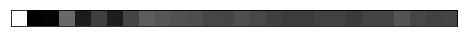

In [23]:
fig, ax = plt.subplots( figsize=(8, 8))
centers = kmeans.cluster_centers_
for center in zip(centers):
    ax.set(xticks=[], yticks=[])
    ax.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
    

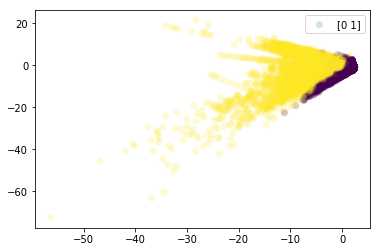

In [24]:
color=kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=y_pred_kmeans,
            s=50, cmap='viridis',label=np.unique(kmeans.labels_),alpha=0.2, edgecolors='none');
plt.legend()

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred_kmeans)
#metrics.acc(y, y_pred_kmeans)

0.47344179063544917

In [26]:
X.shape[-1]

28

In [27]:
dims = [X.shape[-1], 25, 20, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = 'adam'
pretrain_epochs = 100
batch_size = 256
save_dir = './results'

In [28]:
autoencoder, encoder = autoencoder(dims, init=init)


In [29]:

autoencoder .compile(optimizer=pretrain_optimizer, loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history=autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=pretrain_epochs,validation_data=(X_test, X_test),
                    verbose=1, callbacks= [checkpointer, tensorboard]).history 

Instructions for updating:
Use the retry module or similar alternatives.
Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 4s 16us/step - loss: 0.5068 - acc: 0.5344 - val_loss: 0.3388 - val_acc: 0.6502
Epoch 2/100
227451/227451 [==============================] - 12s 54us/step - loss: 0.2567 - acc: 0.6847 - val_loss: 0.2584 - val_acc: 0.7044
Epoch 3/100
227451/227451 [==============================] - 8s 35us/step - loss: 0.2127 - acc: 0.7131 - val_loss: 0.2311 - val_acc: 0.7275
Epoch 4/100
227451/227451 [==============================] - 6s 27us/step - loss: 0.1883 - acc: 0.7337 - val_loss: 0.2203 - val_acc: 0.7453
Epoch 5/100
227451/227451 [==============================] - 6s 24us/step - loss: 0.1699 - acc: 0.7480 - val_loss: 0.1919 - val_acc: 0.7594
Epoch 6/100
227451/227451 [==============================] - 5s 21us/step - loss: 0.1552 - acc: 0.7621 - val_loss: 0.1812 - val_acc: 0.7673
Epoch 7/100
227451/227451 [========

227451/227451 [==============================] - 4s 16us/step - loss: 0.0862 - acc: 0.8295 - val_loss: 0.1187 - val_acc: 0.8225
Epoch 57/100
227451/227451 [==============================] - 4s 16us/step - loss: 0.0862 - acc: 0.8293 - val_loss: 0.1162 - val_acc: 0.8289
Epoch 58/100
227451/227451 [==============================] - 4s 17us/step - loss: 0.0861 - acc: 0.8294 - val_loss: 0.1159 - val_acc: 0.8316
Epoch 59/100
227451/227451 [==============================] - 5s 21us/step - loss: 0.0863 - acc: 0.8295 - val_loss: 0.1164 - val_acc: 0.8313
Epoch 60/100
227451/227451 [==============================] - 3s 13us/step - loss: 0.0861 - acc: 0.8297 - val_loss: 0.1166 - val_acc: 0.8311
Epoch 61/100
227451/227451 [==============================] - 5s 20us/step - loss: 0.0857 - acc: 0.8306 - val_loss: 0.1156 - val_acc: 0.8302
Epoch 62/100
227451/227451 [==============================] - 3s 15us/step - loss: 0.0874 - acc: 0.8283 - val_loss: 0.1151 - val_acc: 0.8282
Epoch 63/100
227451/227451

In [30]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 25)                725       
_________________________________________________________________
encoder_1 (Dense)            (None, 20)                520       
_________________________________________________________________
encoder_2 (Dense)            (None, 10)                210       
_________________________________________________________________
decoder_2 (Dense)            (None, 20)                220       
_________________________________________________________________
decoder_1 (Dense)            (None, 25)                525       
_________________________________________________________________
decoder_0 (Dense)            (None, 28)                728       
Total para

In [31]:
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Validation loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history[l], 'b', label='Training accuracy (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history[l], 'g', label='Validation accuracy (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

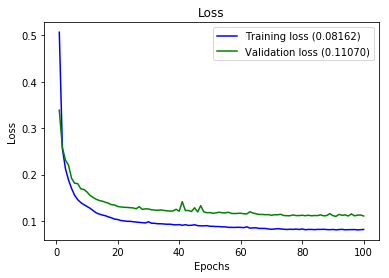

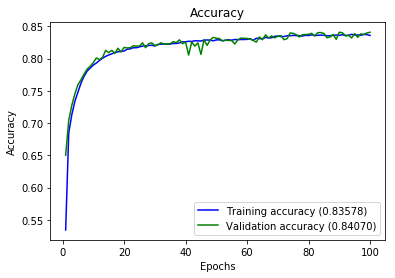

In [32]:
plot_history(history)#5

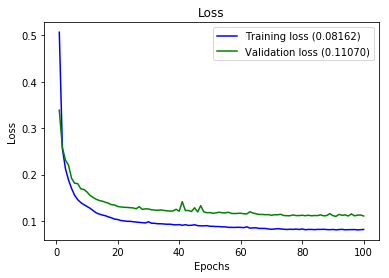

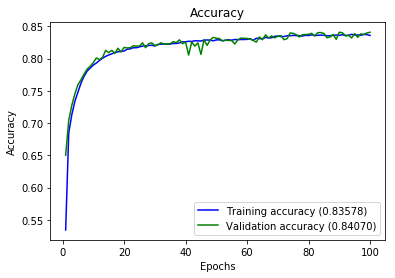

In [33]:
plot_history(history)#18,2

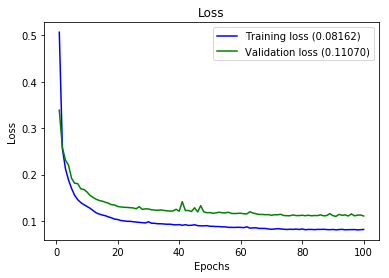

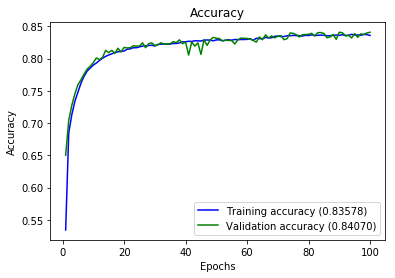

In [34]:
plot_history(history)#10

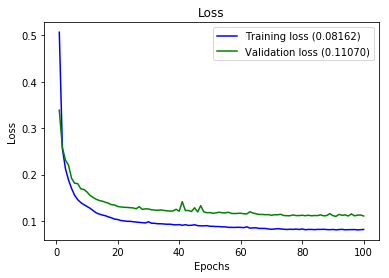

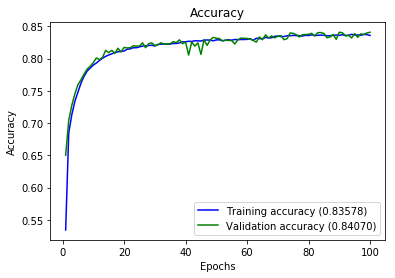

In [35]:
plot_history(history)#10,5

In [36]:
autoencoder.save_weights('ae_weights.h5')

In [37]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [38]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [39]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld', metrics=['accuracy'])



In [40]:
np.any(np.isfinite(X_train))

True

In [41]:
kmeans = KMeans(n_clusters=n_clusters,random_state=42)
encoder_train= encoder.predict(X_train)

In [42]:
encoder_train

array([[-0.36872655,  1.8924984 ,  2.927115  , ..., -1.4669939 ,
         3.2851546 , -1.6891233 ],
       [-3.3462906 ,  0.60244334,  4.1189475 , ..., -2.6380298 ,
         2.370769  , -1.4373307 ],
       [ 3.9458435 ,  4.806749  ,  1.6165565 , ..., -3.9411705 ,
        10.153127  , -1.1025976 ],
       ...,
       [-0.06613624,  1.3900992 ,  1.5306251 , ..., -2.13997   ,
         4.3088894 , -3.0219667 ],
       [ 3.8416898 ,  0.16780502,  3.9919097 , ..., -2.6490884 ,
         7.297634  , -3.501808  ],
       [-1.7225643 ,  3.2913556 ,  5.074564  , ..., -1.3697717 ,
         6.256179  , -0.13061628]], dtype=float32)

In [43]:

train = kmeans.fit(encoder.predict(X_train))
y_pred = kmeans.predict(encoder.predict(X_test))

In [44]:
y_pred_last = np.copy(y_pred)

In [45]:
y_pred.shape

(56962,)

In [46]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [47]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [48]:
loss = 0
index = 0
maxiter = 300
update_interval = 5
index_array = np.arange(X_test.shape[0])

In [49]:
tol = 0.0001 # tolerance threshold to stop training


In [50]:
np.unique(y_pred)

array([0, 1])

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X_test, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc=accuracy_score(y_pred, y_test)
            precision=precision_score(y_pred,y_test)
            print('Iter %d: acc = %.5f, precision = %.5f' % (ite, acc, precision))

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X_test.shape[0])]
    model.train_on_batch(x=X_test[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X_test.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Iter 0: acc = 0.87543, precision = 0.63265
Iter 5: acc = 0.87504, precision = 0.63265
Iter 10: acc = 0.87139, precision = 0.63265
Iter 15: acc = 0.86603, precision = 0.63265
Iter 20: acc = 0.86156, precision = 0.64286
Iter 25: acc = 0.85982, precision = 0.64286
Iter 30: acc = 0.85878, precision = 0.64286
Iter 35: acc = 0.85652, precision = 0.64286
Iter 40: acc = 0.85334, precision = 0.64286
Iter 45: acc = 0.85157, precision = 0.64286
Iter 50: acc = 0.84976, precision = 0.64286
Iter 55: acc = 0.84520, precision = 0.64286
Iter 60: acc = 0.84268, precision = 0.64286
Iter 65: acc = 0.83995, precision = 0.65306
Iter 70: acc = 0.83610, precision = 0.65306
Iter 75: acc = 0.83405, precision = 0.65306
Iter 80: acc = 0.83301, precision = 0.67347
Iter 85: acc = 0.83226, precision = 0.68367
Iter 90: acc = 0.83101, precision = 0.69388
Iter 95: acc = 0.82945, precision = 0.69388
Iter 100: acc = 0.82827, precision = 0.69388
Iter 105: acc = 0.82664, precision = 0.69388
Iter 110: acc = 0.82343, precisi

In [52]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

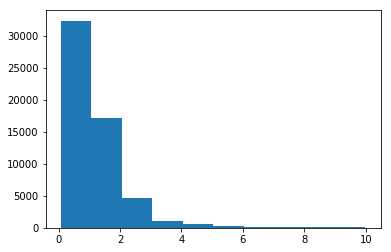

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [54]:
normal_error_df.describe()

,reconstruction_error,true_class
count,56478.000000,56478.0
mean,1.189752,0.0
std,1.007269,0.0
min,0.076522,0.0
25%,0.523731,0.0
50%,0.913390,0.0
75%,1.595415,0.0
max,9.982187,0.0


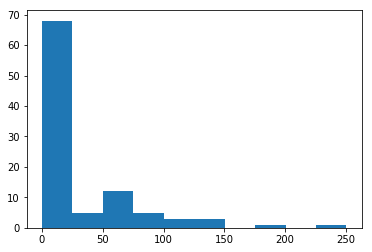

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [56]:
fraud_error_df.describe()

,reconstruction_error,true_class
count,98.000000,98.0
mean,31.118798,1.0
std,43.993266,0.0
min,0.175131,1.0
25%,4.237711,1.0
50%,11.361313,1.0
75%,55.082330,1.0
max,250.316782,1.0


In [57]:
from  sklearn.metrics  import (confusion_matrix, precision_recall_curve, auc,
                                       roc_curve, recall_score, classification_report, f1_score,
                                       precision_recall_fscore_support)

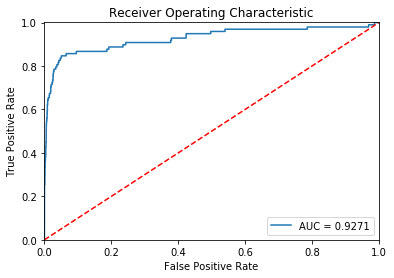

In [58]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

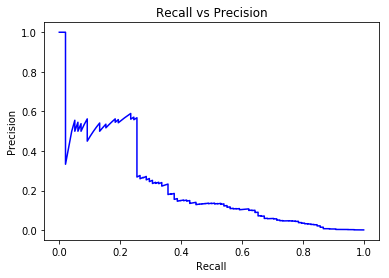

In [59]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

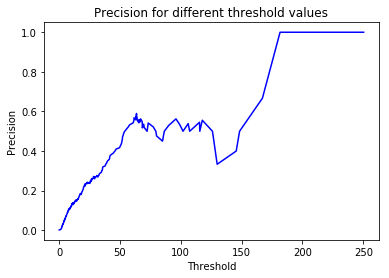

In [60]:

plt.plot(th,  precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

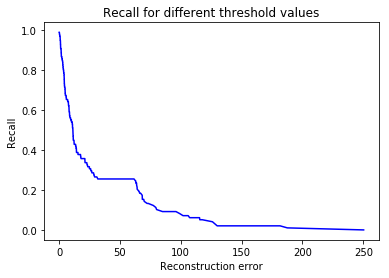

In [61]:

plt.plot(th,  recall[1:],  'b',  label='Threshold-Recall curve Thresho ')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [62]:
threshold = 2.9

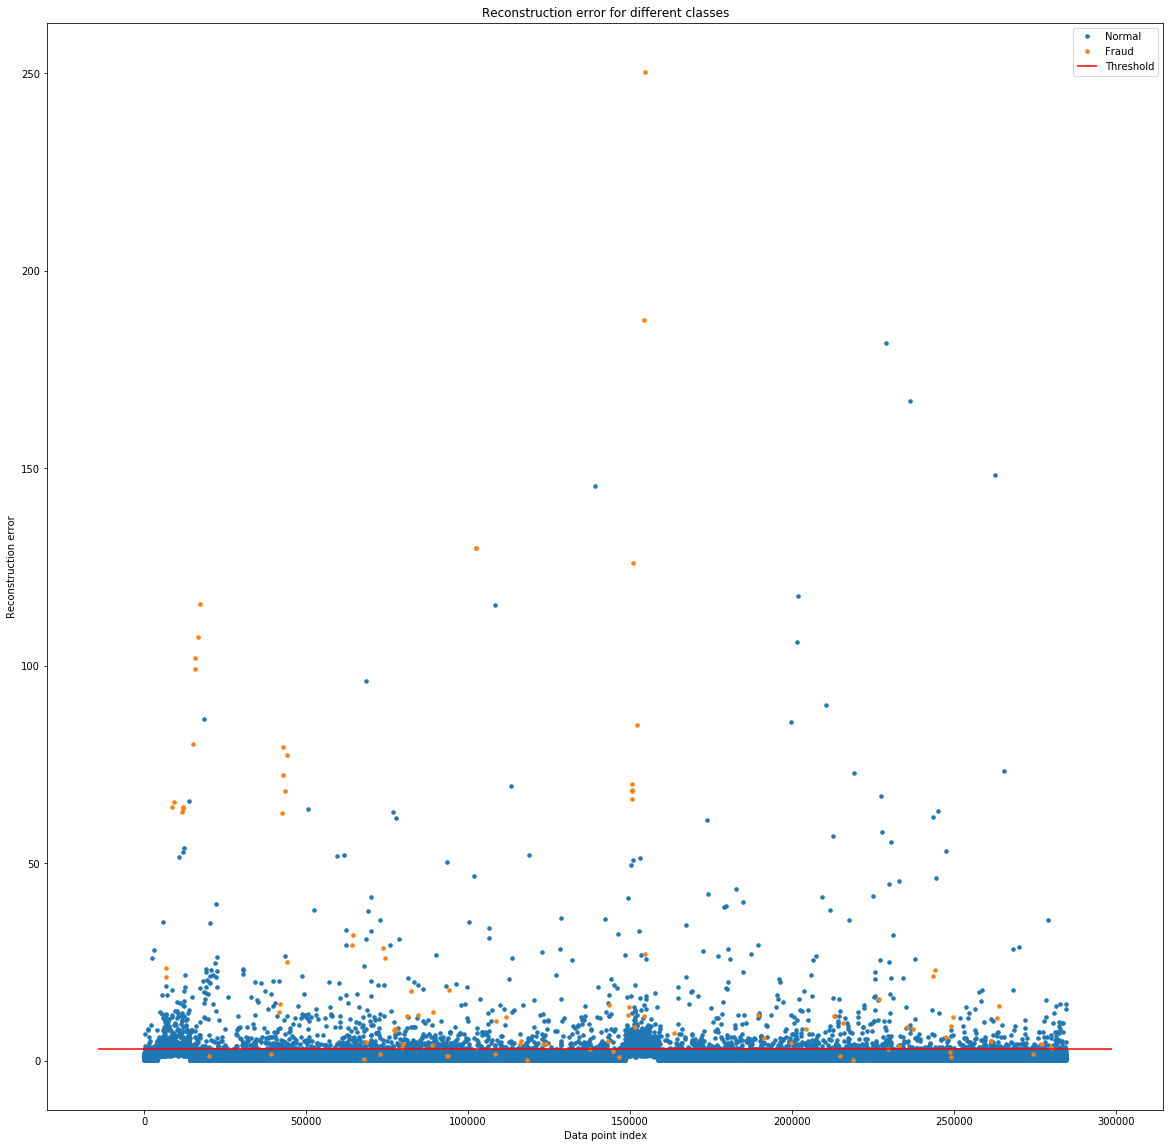

In [63]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

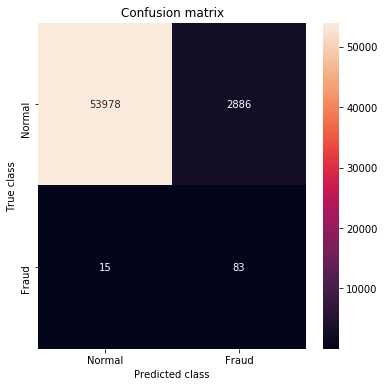

In [64]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [65]:
model.load_weights(save_dir + '/DEC_model_final.h5')

In [66]:
# Eval.
q = model.predict(X_test, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc=accuracy_score(y_test, y_pred)
    precision=precision_score(y_pred,y_test)
    print('Acc = %.5f, precision = %.5f' % (acc, precision))

Acc = 0.63781, precision = 0.89796


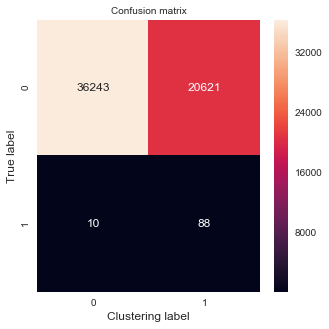

In [67]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=1)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 12});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Clustering label', fontsize=12)
plt.show()

In [68]:
y_pred.shape

(56962,)